# neuron

In [8]:
from cnsproject.network.neural_populations import AELIFPopulation
n = AELIFPopulation((1,), dt=1)

In [9]:
from cnsproject.utils import generate_function
I = generate_function(250, shape=(1,),
           shift={0: 75, 150: 50},
           noise=10,
           population_noise=1)

In [10]:
from cnsproject.network.monitors import Monitor
m = Monitor(n, ['s','w','u'], time=250)
m.simulate(n.forward, inputs={'direct_input': I})

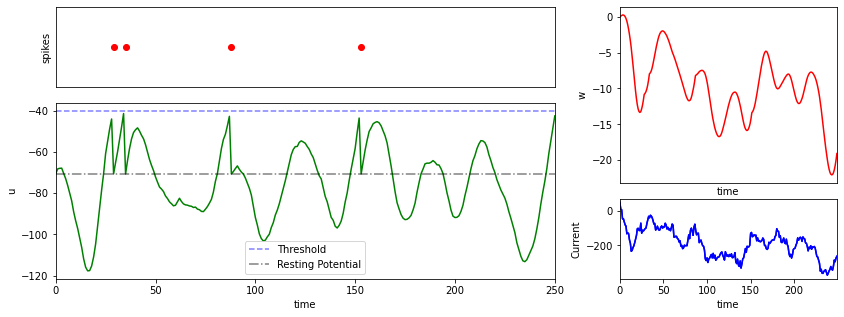

In [11]:
import matplotlib.pyplot as plt
from cnsproject.plotting.plotter import Plotter

plt.figure(figsize=(14,5))
p = Plotter([
    ['s','s','w'],
    ['u','u','w'],
    ['u','u','i'],
], wspace=0.3, monitor=m)
p.neuron_spike('s', x_vis=False)
p.neuron_voltage('u')
p.current_dynamic('i', I=I)
p.adaptation_current_dynamic('w', x_vis=False)
p.show()

# neural_populations

In [6]:
from cnsproject.network.neural_populations import LIFPopulation
n = LIFPopulation((4,50), dt=1)

In [7]:
from cnsproject.utils import generate_function
I = generate_function(250, shape=(4,50),
           shift={0: 75, 150: 50},
           noise=10,
           population_noise=5)

In [8]:
from cnsproject.network.monitors import Monitor
m = Monitor(n, ['s'], time=250)
m.simulate(n.forward, inputs={'direct_input': I})

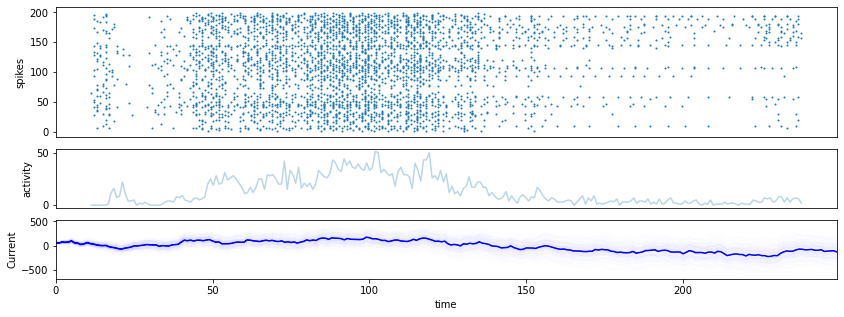

In [9]:
import matplotlib.pyplot as plt
from cnsproject.plotting.plotter import Plotter

plt.figure(figsize=(14,5))
p = Plotter([
    ['s'],
    ['s'],
    ['a'],
    ['i'],
], wspace=0.3, monitor=m)
p.population_activity_raster('s', x_vis=False)
p.population_activity('a', x_vis=False)
p.current_dynamic('i', I=I)
p.show()

# axon_set

In [10]:
import torch
import warnings
warnings.filterwarnings("ignore")

In [11]:
from cnsproject.network.neural_populations import LIFPopulation
n = LIFPopulation((1,), dt=1.)

In [12]:
from cnsproject.utils import generate_function
I = generate_function(2500, shape=(1,),
           shift={0: 50, 150: 50},
           noise=.1,
           population_noise=1)
I = torch.abs(I)

In [13]:
from cnsproject.network.axon_sets import SimpleAxonSet
a1 = SimpleAxonSet(
        population=(1,),
        terminal=(2,),
    )
n.add_axon_set(a1, 'a1')

In [14]:
a2 = SimpleAxonSet(
        population=(1,),
        terminal=(), #terminal shape is 1 per each axon
        is_excitatory=torch.tensor(False),
        delay=20,
    )
n.add_axon_set(a2, 'a2')

In [15]:
from cnsproject.network.axon_sets import SRFAxonSet
a3 = SRFAxonSet(
        population=(1,),
        terminal=(), #terminal shape is 1 per each axon
        delay=0,
        tau=9.,
        max_spikes_at_the_same_time=3,
    )
n.add_axon_set(a3, 'a3')

In [16]:
from cnsproject.network.monitors import Monitor
a1.reset()
a2.reset()
a3.reset()
n.reset()
ma1 = Monitor(a1, ['e'])
ma2 = Monitor(a2, ['e'])
ma3 = Monitor(a3, ['e'])
m = Monitor(n, ['s','u'], time=250)
m.simulate(n.forward, inputs={'direct_input': I}, attendance=[ma1,ma2,ma3])

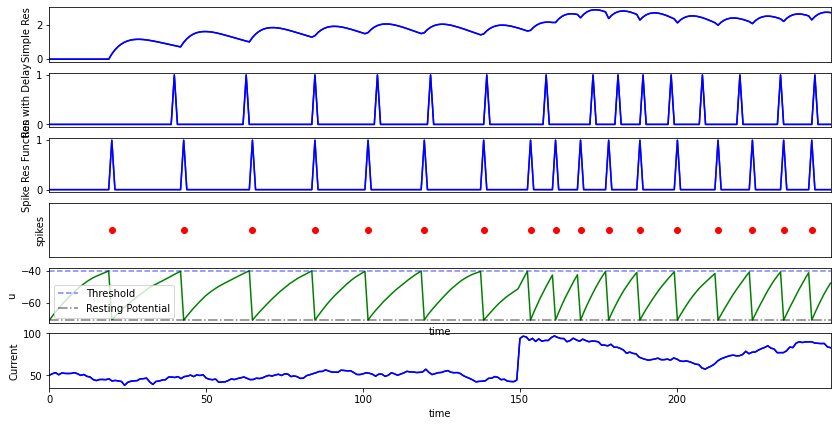

In [17]:
import matplotlib.pyplot as plt
from cnsproject.plotting.plotter import Plotter

plt.figure(figsize=(14,7))
p = Plotter([
    ['a3'],
    ['a2'],
    ['a1'],
    ['s'],
    ['u'],
    ['i'],
], wspace=0.3, monitor=m)
p.current_dynamic('i', I=I[:250])
p.neuron_voltage('u', x_vis=False)
p.neuron_spike('s', x_vis=False)
p.population_plot('a1', y='e', x_vis=False, y_label="Spike Res Function", monitor=ma1, x_lim='fit')
p.population_plot('a2', y='e', x_vis=False, y_label="Res with Delay", monitor=ma2, x_lim='fit')
p.population_plot('a3', y='e', x_vis=False, y_label="Simple Res", monitor=ma3, x_lim='fit')
p.show()

Also works well in multi dims and multo terminals.

# dendrite_set

In [1]:
import torch
import warnings
warnings.filterwarnings("ignore")

In [2]:
from cnsproject.utils import generate_function
I = generate_function(250, shape=(10,),
           shift={0: 50, 150: 50},
           noise=.1,
           population_noise=1)
I = torch.abs(I)

In [3]:
from cnsproject.network.neural_populations import LIFPopulation
n1 = LIFPopulation((10,), dt=1.)
n2 = LIFPopulation((1,), dt=1.)

In [4]:
from cnsproject.network.axon_sets import SimpleAxonSet,SRFAxonSet
a1 = SimpleAxonSet(
    population=(10,),
    terminal=(2,2)
)
n1.add_axon_set(a1, 'a1')
a2 = SRFAxonSet(
        population=(10,),
        scale=2.,
        max_spikes_at_the_same_time=3
    )
n1.add_axon_set(a2, 'a2')

In [5]:
from cnsproject.network.dendrite_sets import SimpleDendriteSet
from cnsproject.network.weight_initializations import norm_initialization,uniform_initialization

d1 = SimpleDendriteSet(
    terminal=(10,2,2),
    population=(1,),
    w=norm_initialization((10,2,2), (1,), w_mean=.5, w_std=.1),
)
n2.add_dendrite_sets(d1, 'd1')

w = torch.zeros(10,1)
w[4:6,0] = 5
d2 = SimpleDendriteSet(
    terminal=(10,),
    population=(1,),
    wmax=5.,
    w=w, # or w=uniform_initialization((10,), (1,), w_range=(0,5))
)
n2.add_dendrite_sets(d2, 'd2')

In [6]:
from cnsproject.network.monitors import Monitor
a1.reset()
a2.reset()
n1.reset()
n2.reset()
d1.reset()
d2.reset()
mn1 = Monitor(n1, ['s'], time=250)
ma1 = Monitor(a1, ['e'])
ma2 = Monitor(a2, ['e'])
md1 = Monitor(d1, ['I'])
md2 = Monitor(d2, ['I'])
mn2 = Monitor(n2, ['u'])

In [7]:
def run(direct_input): # instead of network (for testing step by step)
    d1.forward(a1.get_output())
    d2.forward(a2.get_output())
    n1.forward(direct_input=direct_input)
    n2.forward()
    
mn1.simulate(run, inputs={'direct_input': I},
             attendance=[mn2,ma1,ma2,md1,md2])

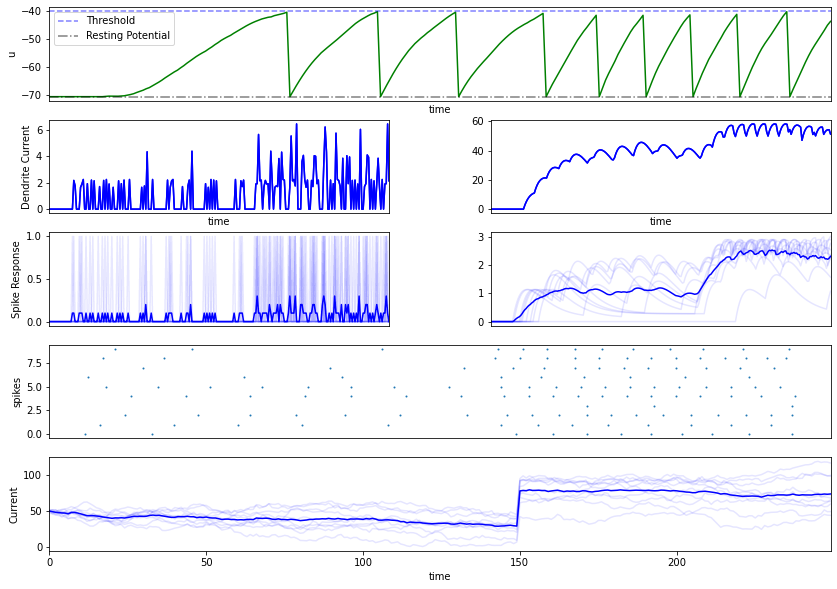

In [8]:
import matplotlib.pyplot as plt
from cnsproject.plotting.plotter import Plotter

plt.figure(figsize=(14,10))
p = Plotter([
    ['u','u'],
    ['d1','d2'],
    ['a1','a2'],
    ['s','s'],
    ['i','i'],
], wspace=0.3)
p.current_dynamic('i', I=I)
p.population_activity_raster('s', x_vis=False, monitor=mn1)
p.spike_response_function('a1', x_vis=False, monitor=ma1)
p.spike_response_function('a2', x_vis=False, y_label='', monitor=ma2)
p.current_dynamic('d1', x_vis=False, y_label="Dendrite Current", monitor=md1)
p.current_dynamic('d2', x_vis=False, y_label='', monitor=md2)
p.neuron_voltage('u', x_vis=False, monitor=mn2)
p.show()

Also works well in multi dims and multo terminals.

In [5]:
from cnsproject.network.neural_populations import LIFPopulation
n1 = LIFPopulation((10,), dt=1.)
n2 = LIFPopulation((10,10), dt=1.)

from cnsproject.network.axon_sets import SimpleAxonSet
a1 = SimpleAxonSet(
    population=(10,),
    terminal=(2,),
    scale=5.,
)
n1.add_axon_set(a1, 'a1')

from cnsproject.network.dendrite_sets import SimpleDendriteSet
from cnsproject.network.weight_initializations import norm_initialization
d1 = SimpleDendriteSet(
    terminal=(10,2),
    population=(10,10),
    wmax=10.,
    w=norm_initialization((10,2), (10,10), w_mean=5., w_std=1.),
)
n2.add_dendrite_sets(d1, 'd1')

from cnsproject.network.monitors import Monitor
n1.reset()
a1.reset()
d1.reset()
n2.reset()
mn1 = Monitor(n1, ['s'], time=250)
ma1 = Monitor(a1, ['e'])
md1 = Monitor(d1, ['I'])
mn2 = Monitor(n2, ['s'])

In [6]:
from cnsproject.utils import generate_function
I = generate_function(250, shape=(10,),
           shift={0: 50, 150: 50},
           noise=.1,
           population_noise=1)
I = torch.abs(I)

def run(direct_input): # instead of network (for testing step by step)
    d1.forward(a1.get_output())
    n1.forward(direct_input=direct_input)
    n2.forward()
    
mn1.simulate(run, inputs={'direct_input': I},
             attendance=[mn2,ma1,md1])

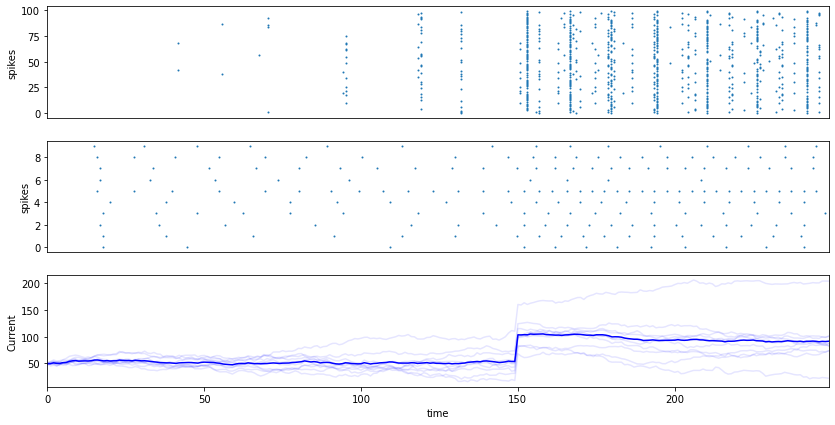

In [7]:
import matplotlib.pyplot as plt
from cnsproject.plotting.plotter import Plotter

plt.figure(figsize=(14,7))
p = Plotter([
    ['s2'],
    ['s1'],
    ['i'],
], wspace=0.3)
p.current_dynamic('i', I=I)
p.population_activity_raster('s1', y='s', x_vis=False, monitor=mn1)
p.population_activity_raster('s2', y='s', x_vis=False, monitor=mn2)
p.show()

# synapse_set

In [1]:
import torch
import warnings
warnings.filterwarnings("ignore")

from cnsproject.network.neural_populations import LIFPopulation
n1 = LIFPopulation((10,), dt=1.)
n2 = LIFPopulation((10,10), dt=1.)

from cnsproject.network.axon_sets import SimpleAxonSet
a1 = SimpleAxonSet(
    population=(10,),
    terminal=(2,),
    scale=5.,
)
n1.add_axon_set(a1, 'a1')

from cnsproject.network.dendrite_sets import SimpleDendriteSet
from cnsproject.network.weight_initializations import norm_initialization
d1 = SimpleDendriteSet(
    terminal=(10,2),
    population=(10,10),
    wmax=10.,
    w=norm_initialization((10,2), (10,10), w_mean=5., w_std=1.),
)
n2.add_dendrite_sets(d1, 'd1')

from cnsproject.network.monitors import Monitor
n1.reset()
a1.reset()
d1.reset()
n2.reset()
mn1 = Monitor(n1, ['s'], time=250)
ma1 = Monitor(a1, ['e'])
md1 = Monitor(d1, ['I'])
mn2 = Monitor(n2, ['s'])

from cnsproject.utils import generate_function
import torch
I = generate_function(250, shape=(10,),
           shift={0: 50, 150: 50},
           noise=.1,
           population_noise=1)
I = torch.abs(I)

In [2]:
from cnsproject.network.synapse_sets import SimpleSynapseSet
from cnsproject.network.connectivity_patterns import rfnopp_connectivity

s1 = SimpleSynapseSet(
    axon_set = a1,
    dendrite_set = d1,
    dt = 1.,
    connectivity = rfnopp_connectivity((10,2),(10,10), c_rate=.8)
)
s1.reset()

In [3]:
def run(direct_input): # instead of network (for testing step by step)
    s1.forward()
    n1.forward(direct_input=direct_input)
    n2.forward()
    
mn1.simulate(run, inputs={'direct_input': I},
             attendance=[mn2,ma1,md1])

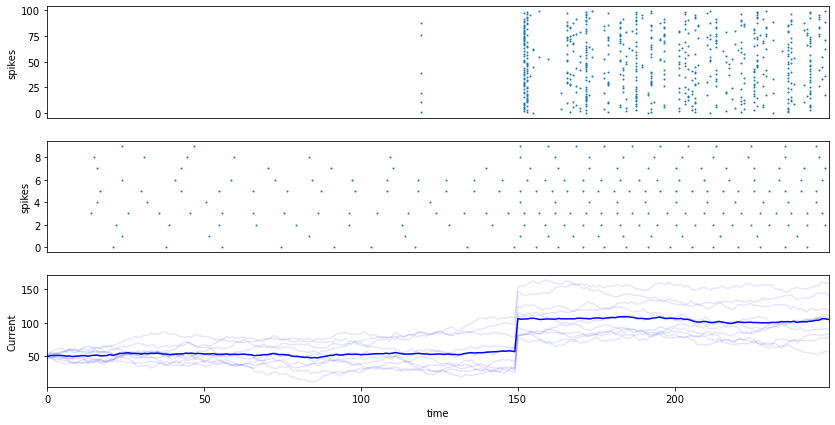

In [4]:
import matplotlib.pyplot as plt
from cnsproject.plotting.plotter import Plotter

plt.figure(figsize=(14,7))
p = Plotter([
    ['s2'],
    ['s1'],
    ['i'],
], wspace=0.3)
p.current_dynamic('i', I=I)
p.population_activity_raster('s1', y='s', x_vis=False, monitor=mn1)
p.population_activity_raster('s2', y='s', x_vis=False, monitor=mn2)
p.show()

Connection can be not fully described!

In [8]:
import torch
import warnings
warnings.filterwarnings("ignore")

from cnsproject.network.neural_populations import LIFPopulation
n1 = LIFPopulation((2,), dt=1.)
n2 = LIFPopulation((3,3), dt=1.)

from cnsproject.network.axon_sets import SimpleAxonSet
a1 = SimpleAxonSet(
    population=(2,),
    terminal=(2,),
    scale=25.,
)
n1.add_axon_set(a1, 'a1')

from cnsproject.network.dendrite_sets import SimpleDendriteSet
from cnsproject.network.weight_initializations import norm_initialization
d1 = SimpleDendriteSet(
    terminal=(1,2),
    population=(3,3),
    wmax=10.,
    w=norm_initialization((1,2), (3,3), w_mean=5., w_std=1.),
)
n2.add_dendrite_sets(d1, 'd1')

from cnsproject.network.monitors import Monitor
n1.reset()
a1.reset()
d1.reset()
n2.reset()
mn1 = Monitor(n1, ['s'], time=250)
ma1 = Monitor(a1, ['e'])
md1 = Monitor(d1, ['I'])
mn2 = Monitor(n2, ['s'])

from cnsproject.utils import generate_function
import torch
I = generate_function(250, shape=(2,),
           shift={0: 50, 150: 50},
           noise=.1,
           population_noise=1)
I = torch.abs(I)

from cnsproject.network.synapse_sets import SimpleSynapseSet
connectivity = torch.tensor(
    [[
        [[True, False],[False, True]],
        [[False, True],[False, True]],
        [[True, False],[True, False]],
    ],[
        [[True, False],[True, False]],
        [[True, False],[False, True]],
        [[True, False],[False, True]],
    ],[
        [[False, True],[False, True]],
        [[False, True],[False, True]],
        [[False, True],[False, True]],
    ]]
).T

s1 = SimpleSynapseSet(
    axon_set = a1,
    dendrite_set = d1,
    dt = 1.,
    connectivity = connectivity
)

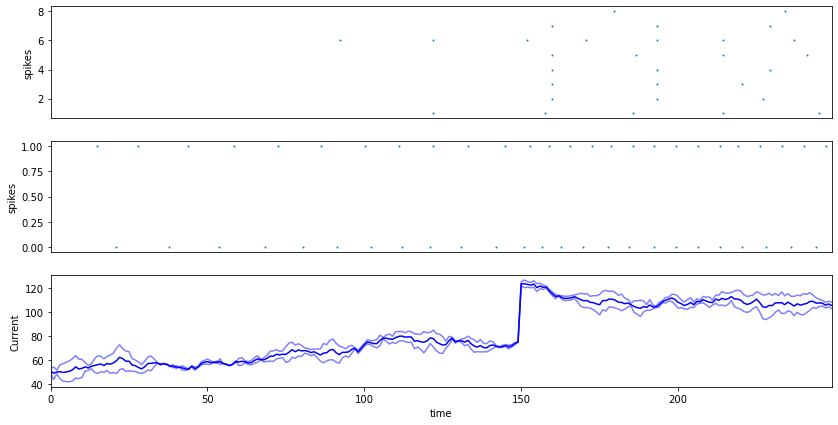

In [9]:
def run(direct_input): # instead of network (for testing step by step)
    s1.forward()
    n1.forward(direct_input=direct_input)
    n2.forward()
    
mn1.simulate(run, inputs={'direct_input': I},
             attendance=[mn2,ma1,md1])

import matplotlib.pyplot as plt
from cnsproject.plotting.plotter import Plotter

plt.figure(figsize=(14,7))
p = Plotter([
    ['s2'],
    ['s1'],
    ['i'],
], wspace=0.3)
p.current_dynamic('i', I=I)
p.population_activity_raster('s1', y='s', x_vis=False, monitor=mn1)
p.population_activity_raster('s2', y='s', x_vis=False, monitor=mn2)
p.show()

# network

In [28]:
import torch
import warnings
warnings.filterwarnings("ignore")
from cnsproject.network.network import Network
from cnsproject.network.neural_populations import LIFPopulation
from cnsproject.network.axon_sets import SimpleAxonSet
from cnsproject.network.dendrite_sets import SimpleDendriteSet
from cnsproject.network.weight_initializations import norm_initialization
from cnsproject.network.synapse_sets import SimpleSynapseSet
from cnsproject.network.connectivity_patterns import rfnopp_connectivity,in_rfnopp_connectivity
from cnsproject.network.monitors import Monitor
from cnsproject.utils import generate_function
import matplotlib.pyplot as plt
from cnsproject.plotting.plotter import Plotter

In [38]:
n1 = LIFPopulation((4 ,50))
n2 = LIFPopulation((25,  ))
n3 = LIFPopulation((12,2 ))
a1_1 = SimpleAxonSet(population=n1.shape, scale=15)
a2_2 = SimpleAxonSet(population=n2.shape, scale=30)
a1_3 = SimpleAxonSet(population=n1.shape, scale=75)
a3_1 = SimpleAxonSet(population=n3.shape, scale=50, is_excitatory=False)
a2_3 = SimpleAxonSet(population=n2.shape, scale=150)
a3_2 = SimpleAxonSet(population=n3.shape, scale=100, is_excitatory=False)
n1.add_axon_set(a1_1, 'a1_1')
n1.add_axon_set(a1_3, 'a1_3')
n2.add_axon_set(a2_2, 'a2_2')
n2.add_axon_set(a2_3, 'a2_3')
n3.add_axon_set(a3_1, 'a3_1')
n3.add_axon_set(a3_2, 'a3_2')
d1_1 = SimpleDendriteSet(terminal=n1.shape, population=n1.shape, w=norm_initialization(n1.shape,n1.shape))
d2_2 = SimpleDendriteSet(terminal=n2.shape, population=n2.shape, w=norm_initialization(n2.shape,n2.shape))
d1_3 = SimpleDendriteSet(terminal=n1.shape, population=n3.shape, w=norm_initialization(n1.shape,n3.shape))
d3_1 = SimpleDendriteSet(terminal=n3.shape, population=n1.shape, w=norm_initialization(n3.shape,n1.shape))
d2_3 = SimpleDendriteSet(terminal=n2.shape, population=n3.shape, w=norm_initialization(n2.shape,n3.shape))
d3_2 = SimpleDendriteSet(terminal=n3.shape, population=n2.shape, w=norm_initialization(n3.shape,n2.shape))
n1.add_dendrite_sets(d1_1, 'd1_1')
n1.add_dendrite_sets(d3_1, 'd3_1')
n2.add_dendrite_sets(d2_2, 'd2_2')
n2.add_dendrite_sets(d3_2, 'd3_2')
n3.add_dendrite_sets(d1_3, 'd1_3')
n3.add_dendrite_sets(d2_3, 'd2_3')
s1_1 = SimpleSynapseSet(axon_set=a1_1, dendrite_set=d1_1, connectivity=in_rfnopp_connectivity(n1.shape))
s2_2 = SimpleSynapseSet(axon_set=a2_2, dendrite_set=d2_2, connectivity=in_rfnopp_connectivity(n2.shape), c_rate=.4)
s1_3 = SimpleSynapseSet(axon_set=a1_3, dendrite_set=d1_3, connectivity=rfnopp_connectivity(n1.shape,n3.shape), c_rate=.2)
s3_1 = SimpleSynapseSet(axon_set=a3_1, dendrite_set=d3_1, connectivity=rfnopp_connectivity(n3.shape,n1.shape), c_rate=.2)
s2_3 = SimpleSynapseSet(axon_set=a2_3, dendrite_set=d2_3, connectivity=rfnopp_connectivity(n2.shape,n3.shape), c_rate=.8)
s3_2 = SimpleSynapseSet(axon_set=a3_2, dendrite_set=d3_2, connectivity=rfnopp_connectivity(n3.shape,n2.shape), c_rate=.8)
net = Network(dt=1.)
net.add_population(n1, 'n1')
net.add_population(n2, 'n2')
net.add_population(n3, 'n3')
net.add_synapse(s1_1, 's1_1')
net.add_synapse(s2_2, 's2_2')
net.add_synapse(s1_3, 's1_3')
net.add_synapse(s3_1, 's3_1')
net.add_synapse(s2_3, 's2_3')
net.add_synapse(s3_2, 's3_2')

In [39]:
mn1 = Monitor(n1, ['s'])
mn2 = Monitor(n2, ['s'])
mn3 = Monitor(n3, ['s'])
m = Monitor(net, state_calls={
    'i3_1': d3_1.get_output,
    'cI': n1.collect_I,
}, time=250)

I1 = torch.abs(generate_function(250, shape=n1.shape, shift={0: 35}, noise=.1, population_noise=.2))
I2 = torch.abs(generate_function(250, shape=n2.shape, shift={0: 35, 100: 50}, noise=.1, population_noise=.2))

m.simulate(net.forward, inputs={'n1_direct_input': I1, 'n2_direct_input': I2},
             attendance=[mn1,mn2,mn3])

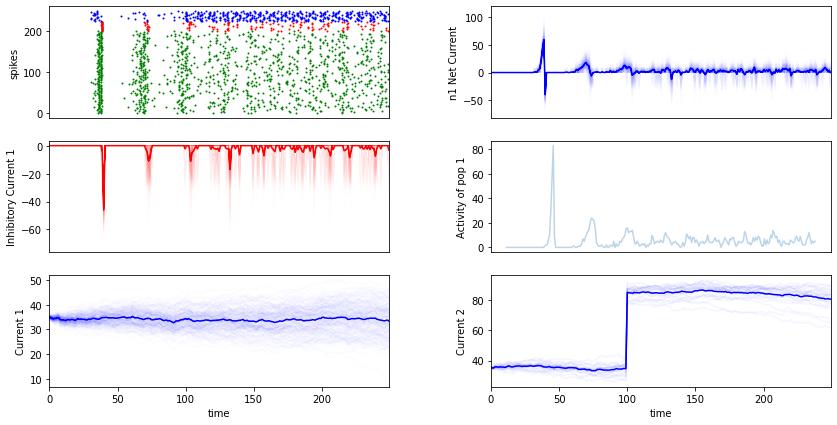

In [40]:
plt.figure(figsize=(14,7))
p = Plotter([
    ['s','ci'],
    ['e1','a1'],
    ['i1','i2'],
], wspace=0.3)
p.current_dynamic('i1', I=I1, y_label="Current 1", population_alpha=.01)
p.current_dynamic('i2', I=I2, y_label="Current 2", population_alpha=.04)
p.current_dynamic('e1', y='i3_1', y_label="Inhibitory Current 1", monitor=m, color='r', x_vis=False, x_label='')
p.current_dynamic('ci', y='cI', y_label="n1 Net Current", monitor=m, x_vis=False, x_label='')
p.population_activity('a1', y_label="Activity of pop 1", monitor=mn1, x_vis=False, x_label='')
p.population_activity_raster('s', monitor=mn3, color='r', start=n1.s.numel(), x_vis=False, x_label='')
p.population_activity_raster('s', monitor=mn1, color='g', additive=True)
p.population_activity_raster('s', monitor=mn2, color='b', additive=True, start=n1.s.numel()+n3.s.numel())
p.show()